# Astropy version: 5.3.4
# The input file contains a dic object with two keys, ['transmission', 'dva'].
# 'transmission' leads to another dict containing the transmission data.
# The data for each redshift is accessed with ['6', '6h', '7', '8', '10'], where 6h corresponds to 6.5.
# 'dva' leads to the 100 velocity offset values for the data in km/s.
# The first and last value of dva is 135.6 and 24549.7.


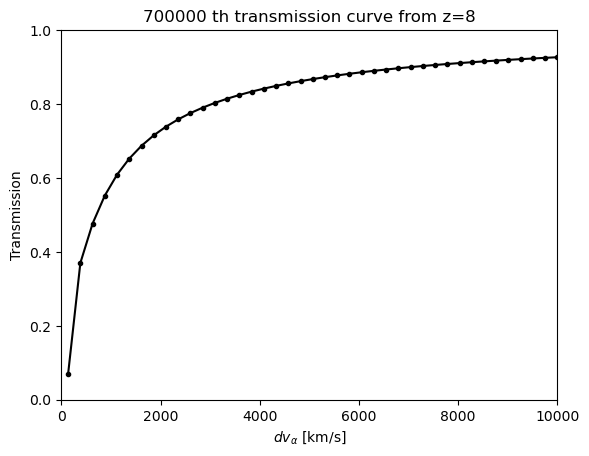

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy; print(f'# Astropy version: {astropy.__version__}')
from astropy.io import fits
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.special import erfc
import gc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.colors as mcolors
from sig_a_app import sig_a_app
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

c_sl = 2.99792e5; Lya = 1215.67 # speed of light in km/s and Lya wavelength in Å
zsList = ['6', '6h', '7', '8', '10']

datain = np.load('RFC4LBGDW_input_data.npy',allow_pickle=True).item()
print(f'# The input file contains a dic object with two keys, {list(datain.keys())}.')

print(f'# \'transmission\' leads to another dict containing the transmission data.')
print(f'# The data for each redshift is accessed with {zsList}, where 6h corresponds to 6.5.')
print(f"# \'dva\' leads to the {len(datain['dva'])} velocity offset values for the data in km/s.")
dvaArr = datain['dva']; TrArr = datain['transmission']
zLabel = []
for zs in zsList:
    zLabel+=len(TrArr[zs])*[zs]
TrArr = np.concatenate((TrArr['6'],TrArr['6h'],TrArr['7'],TrArr['8'],TrArr['10']),axis=0)
print(f'# The first and last value of dva is {round(dvaArr[0],1)} and {round(dvaArr[-1],1)}.')
datain.clear(); gc.collect()

iLOS = 700_000
plt.plot(dvaArr,TrArr[iLOS,:],'k.-')
plt.ylim(0,1); plt.ylabel(r'Transmission')
plt.xlim(0,1e4); plt.xlabel(r'$dv_\alpha~[{\rm km}/{\rm s}]$')
plt.title(f'{iLOS} th transmission curve from z={zLabel[iLOS]}')
plt.show()

In [30]:

###################################################################################################################################
### This block should be editted by the user appropriately to provide 'l_rest', 'flux', and 'flux_err' needed for the next steps. #
###################################################################################################################################
name, R, Lyadva, LyaEW = 'GN-z11', 32, 555., 18.
print(f"########## Read in {name} spectrum observed with spectrum resolution of {R} ##########\n")
print(f"# Velocity offset and EW of the Lya emission line are dva={Lyadva} km/s and {LyaEW} Å, respectively.\n")
dataFile1, redshift1 = 'hlsp_jades_jwst_nirspec_goods-n-mediumhst-00003991_clear-prism_v1.0_x1d.fits', 10.605965
dataFile2, redshift2 = 'hlsp_jades_jwst_nirspec_goods-n-mediumjwst-00005591_clear-prism_v1.0_x1d.fits', 10.604423


def readData(dataFile,redshift,printHeader=False):
    print('# input data file: '+dataFile)
    hdul = fits.open(dataFile)
    waveKey, fluxKey, errorKey = hdul[1].data.columns.names[:3]

    if printHeader:
        print(hdul[1].header)
    l_rest =  hdul[1].data[waveKey]/(1+redshift)*1e4
    ind = np.where(l_rest>2000.)[0][0]
    flux = hdul[1].data[fluxKey]; flux_err = hdul[1].data[errorKey]
    flux_err /= flux[ind]; flux /= flux[ind] # Rescaling the flux and error data to order unity
    hdul.close()
    
    return l_rest, flux, flux_err

# GN-z11 has two publicly vailable spectra. Combining the spectra to increase the SNR. 
l_rest1, flux1, flux_err1 = readData(dataFile1, redshift1)
l_rest2, flux2, flux_err2 = readData(dataFile2, redshift2)
redshift = (redshift1+redshift2)/2

mask = np.logical_and(flux1==flux1,np.logical_and(l_rest1>1200,l_rest1<4510))
l_rest1, flux1, flux_err1 = l_rest1[mask], flux1[mask], flux_err1[mask] ### Trimming the arrays

mask = np.logical_and(flux2==flux2,np.logical_and(l_rest2>1200,l_rest2<4510))
l_rest2, flux2, flux_err2 = l_rest2[mask], flux2[mask], flux_err2[mask] ### Trimming the arrays

l_rest = (l_rest1+l_rest2)/2
flux = (flux1/flux_err1+flux2/flux_err2)/(1/flux_err1+1/flux_err2)
flux_err = (1/(1/flux_err1**2 + 1/flux_err2**2))**0.5

# print(flux2[:3])


print(f"# 'l_rest' contains rest-frame wavelengths of the {len(l_rest)} bins in Å between {round(np.min(l_rest),1)} and {round(np.max(l_rest),1)} Å.")
print(f"# 'flux' contains the flux rescaled to order of unity.")
print(f"# 'flux_err' contains the flux error in the same scale.")
print(f"# The ratio between 'flux' and 'flux_err' gives the SNR of each bin. ")

########## Read in GN-z11 spectrum observed with spectrum resolution of 32 ##########

# Velocity offset and EW of the Lya emission line are dva=555.0 km/s and 18.0 Å, respectively.

# input data file: hlsp_jades_jwst_nirspec_goods-n-mediumhst-00003991_clear-prism_v1.0_x1d.fits
# input data file: hlsp_jades_jwst_nirspec_goods-n-mediumjwst-00005591_clear-prism_v1.0_x1d.fits
[1208.7774712  1219.11777988 1229.49103101]
# 'l_rest' contains rest-frame wavelengths of the 537 bins in Å between 1208.8 and 4507.9 Å.
# 'flux' contains the flux rescaled to order of unity.
# 'flux_err' contains the flux error in the same scale.
# The ratio between 'flux' and 'flux_err' gives the SNR of each bin. 


# Find a power-law fit for the spectrum using data between 1300 and 2600 Å.
# The fitting function for the contiuum flux is 3.17*(λ/1225.67Å)^(-2.24).




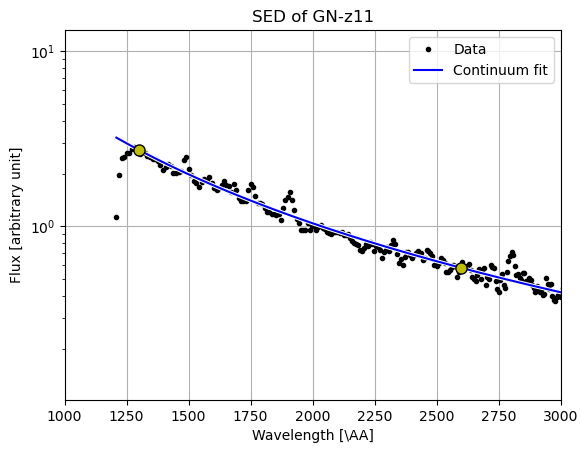

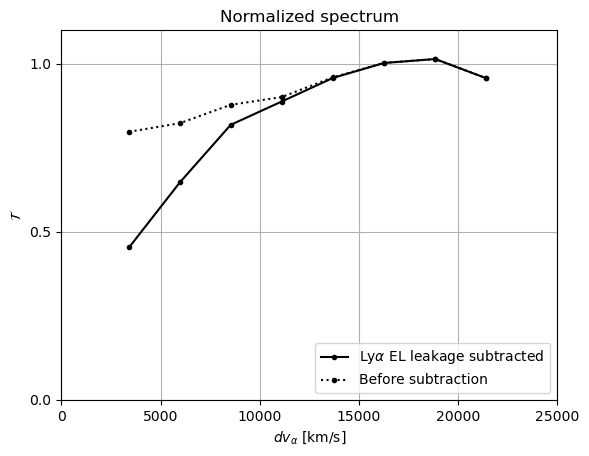

In [57]:

def powerLaw(l,a,b):
    return a * np.power(l/Lya, b)

def continuum(l,a,b): # This is redundant now, but will be needed when we add another component to the contiuum fitting. 
    return powerLaw(l, a, b)

lmin, lmax = 1300, 2600
il, iu = np.argmin((l_rest-lmin)**2), np.argmin((l_rest-lmax)**2)
print(f'# Find a power-law fit for the spectrum using data between {lmin} and {lmax} Å.')

X = l_rest[il:iu]; y = flux[il:iu]
popt, pcov = curve_fit(continuum,X,y,bounds=((0,-5),(np.inf,2)),p0=(1,-1),method='trf')
print(f'# The fitting function for the contiuum flux is {round(popt[0],2)}*(λ/1225.67Å)^({round(popt[1],2)}).\n\n')

plt.plot(l_rest, flux, 'k.', label='Data')
plt.plot(l_rest,continuum(l_rest, *popt),'w',lw=3); plt.plot(l_rest,continuum(l_rest, *popt),'b',label='Continuum fit')
Fl, Fu = continuum(np.array([lmin, lmax]), *popt)
plt.plot([lmin, lmax],[Fl, Fu],'ko',markersize=8); plt.plot([lmin, lmax],[Fl, Fu],'yo',markersize=6)
plt.title(r'SED of '+f'{name}'); plt.legend()
plt.xlabel(r'Wavelength [\AA]'); plt.xlim(1e3,3e3); plt.grid()
plt.ylabel('Flux [arbitrary unit]'); plt.ylim(np.min(y)/5,np.max(y)*5); plt.yscale('log')
plt.show()

dvaMax = 25000
dvaSpec = ((l_rest-Lya)/Lya*c_sl)
il, iu = np.where(dvaSpec[:-1]+dvaSpec[1:] > 2000)[0][0]+1, np.argmin((dvaSpec-dvaMax)**2)
lMock = l_rest[il:iu]; dvaMock = dvaSpec[il:iu]
# noiseMock = flux_err[il:iu]/flux[il:iu]
noiseMock = flux_err[il:iu]/continuum(l_rest[il:iu],*popt)

sig = (Lya/R)/2.355
def LyaEL(l):
    loff = Lyadva/c_sl*Lya
    return LyaEW/(2*np.pi*sig**2)**0.5*np.exp(-(l-Lya-loff)**2/(2*sig**2))

targetSpec = flux[il:iu]/continuum(l_rest[il:iu],*popt)-LyaEL(l_rest[il:iu])
targetSpecNoElSubt = flux[il:iu]/continuum(l_rest[il:iu],*popt)
plt.plot(dvaSpec[il:iu],targetSpec,'k.-',label=r'Ly$\alpha$ EL leakage subtracted')
plt.plot(dvaSpec[il:iu],targetSpecNoElSubt,'k:.',label=r'Before subtraction')
plt.xlabel(r'$dv_\alpha$ [km/s]'); plt.xlim(0,dvaMax)
plt.ylabel(r'$\mathcal{T}$'); plt.ylim(0,1.1); plt.yticks([0,0.5,1]); plt.grid()
plt.title('Normalized spectrum'); plt.legend(loc=4)


# Total number of spectra: 1018980
# Applying smoothing for spectral resolution of 32
# Adding random noise & DLA


[]

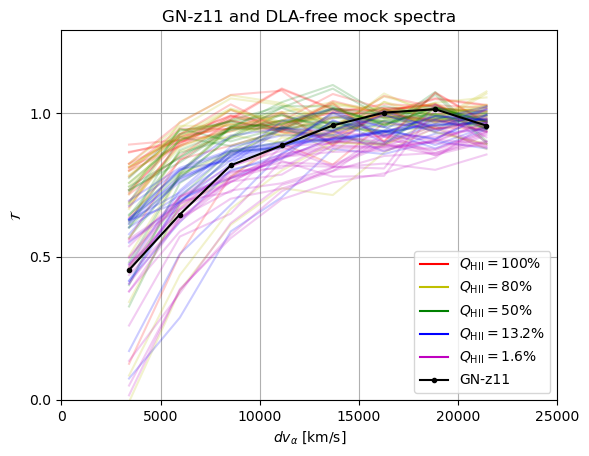

In [32]:

z2cX = {'6':['r','100'],'6h':['y','80'],'7':['g','50'],'8':['b','13.2'],'10':['m','1.6']}
ngal = len(TrArr[:,0]); print(f"# Total number of spectra: {ngal}")
TrMock = np.ones((ngal,len(dvaMock)))


ddva = dvaArr[1]-dvaArr[0]
sig = (Lya/R)/2.355
def blueSideFlux(x):
    return erfc(x/2**0.5)/2
def gaussian(x, mu=0., sig=1.):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

sigv = c_sl/(R*2.355)
print(f'# Applying smoothing for spectral resolution of {R}')
for i in range(il,iu):
    dval = (l_rest[i-1:i+1].mean()-Lya)/Lya*c_sl
    dvau = (l_rest[i:i+2].mean()-Lya)/Lya*c_sl
    xl = dval/sigv; xu = dvau/sigv
    TrMock[:,i-il]-= integrate.quad(lambda x: blueSideFlux(x), xl, xu)[0]/(xu-xl)

for idva, dva_in in enumerate(dvaArr):
    for i in range(il,iu):
        dval = ((l_rest[i-1:i+1].mean()-Lya)/Lya*c_sl - dva_in)
        dvau = ((l_rest[i  :i+2].mean()-Lya)/Lya*c_sl - dva_in)
        dF = integrate.quad(lambda x: gaussian(x), dval/sigv, dvau/sigv)[0]/((dvau-dval)/ddva)
        TrMock[:,i-il] -= dF*(1-TrArr[:, idva])

TrDlaMock = np.copy(TrMock)
print(f'# Adding random noise & DLA')
np.random.seed(1)
noiseArr = np.zeros(TrMock.shape)
tauDlaArr = np.array([sig_a_app(dva_in/c_sl*Lya,1.e4) for dva_in in dvaMock])

for iLOS in range(TrMock.shape[0]):
    noiseArr[iLOS,:] = np.random.randn(len(noiseMock))*noiseMock
    TrMock[iLOS,:] = TrMock[iLOS,:] + noiseArr[iLOS,:]
    NHI = 10**(20.3+np.random.rand()*2)
    TrDlaMock[iLOS,:] = TrDlaMock[iLOS,:]*np.exp(-tauDlaArr*NHI) + noiseArr[iLOS,:]

#####################################################################################################
nline=45
xl, xu, yl, yu = 0, 25000, 0, 1.29
for iLOS in range(0,ngal,ngal//nline):
    cin, Xin = z2cX[zLabel[iLOS]]
    plt.plot(dvaMock,TrMock[iLOS,:],cin+'-',alpha=0.2)
    plt.plot(dvaMock,TrDlaMock[iLOS,:],cin+'-',alpha=0.2)
for zs in z2cX:
    cin, Xin = z2cX[zs]
    plt.plot([xl,xu],[yu+1,yu+1],cin+'-',label=r'$Q_{\rm HII}='+Xin+'\%$')
plt.plot(dvaMock,flux[il:iu]/continuum(l_rest[il:iu],*popt)-LyaEL(l_rest[il:iu]),'k.-',label=name)
plt.xlabel(r'$dv_\alpha$ [km/s]'); plt.ylabel(r'$\mathcal{T}$')
plt.yticks([0,0.5,1]); plt.grid()
plt.axis([xl,xu,0,yu])
plt.title(f'{name} and DLA-free mock spectra'); plt.legend(loc=4)
plt.plot()
#####################################################################################################


In [34]:

n_estimators = 20; max_depth = 10

QCLF     = RandomForestClassifier(random_state=42, n_jobs=-1,max_depth=max_depth,n_estimators=n_estimators)
QCLF2D   = RandomForestClassifier(random_state=42, n_jobs=-1,max_depth=max_depth,n_estimators=n_estimators)

DLACLF   = RandomForestClassifier(random_state=43, n_jobs=-1,max_depth=max_depth,n_estimators=n_estimators)
DLACLF2D = RandomForestClassifier(random_state=43, n_jobs=-1,max_depth=max_depth,n_estimators=n_estimators)

labels = np.array([zLabel+zLabel, ['0']*len(TrMock)+['1']*len(TrDlaMock)]).T

test_size = 0.95
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((TrMock,TrDlaMock),axis=0),labels,test_size=test_size,random_state=42)
print(f'Training/Test set size: {X_train.shape[0]}/{X_test.shape[0]}')
# print(X_train.shape,y_train.shape)
QCLF.fit(X_train[:,:],y_train[:,0])
QCLF2D.fit(X_train[:,:2],y_train[:,0])
DLACLF.fit(X_train[:,:],y_train[:,1])
DLACLF2D.fit(X_train[:,:2],y_train[:,1])

print(targetSpec) 
#
######### Prediction
# X_in = [y/yfit]
print('# Predicted z = '+QCLF.predict([targetSpec])[0])
print('# Prediction probability ',100*QCLF.predict_proba([targetSpec])[0],'% [100, 80, 50, 13, 0%]')

print('# DLA existence: '+DLACLF.predict([targetSpec])[0])
print('# DLA existence prob: ',DLACLF.predict_proba([targetSpec])[0]*100,'% [No Yes]')


Training/Test set size: 101898/1936062
[0.45375009 0.6471201  0.81864236 0.88812076 0.95814704 1.00285575
 1.0144989  0.95721937]
# Predicted z = 8
# Prediction probability  [ 8.73912953 10.51088492 13.84679078 18.92161735 47.98157743] % [100, 80, 50, 13, 0%]
# DLA existence: 1
# DLA existence prob:  [15.74132034 84.25867966] % [No Yes]


<Figure size 600x600 with 0 Axes>

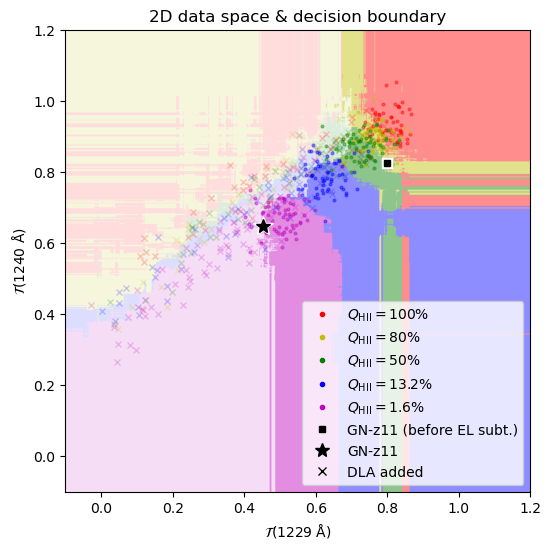

# The final result is [ 8.73912953 10.51088492 13.84679078 18.92161735 47.98157743]% for Q_HII=[100.0, 80.0, 50.0, 13.2, 1.6]%
# 68% upper bound: Q_HII < 34.2 %


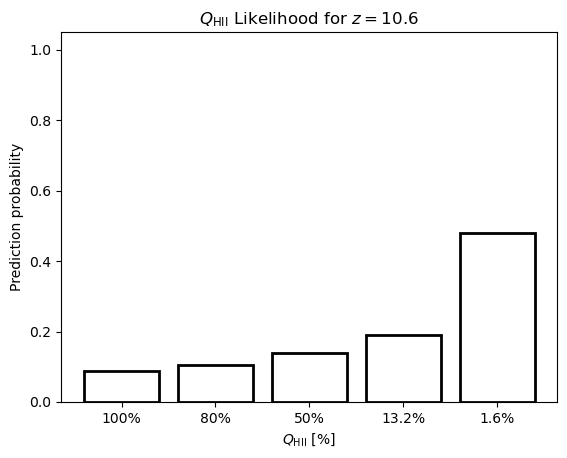

In [84]:
xdat = 0; ydat = 1; nskip = ngal//300; alpha_in = 0.4 # Parameters for the 2D figure
z2cX = {'6':['r','100'],'6h':['y','80'],'7':['g','50'],'8':['b','13.2'],'10':['m','1.6']}

#############################################################################
xl, xu, yl, yu = -0.1,1.2,-0.1,1.2
nx, ny = 1000,1000
bmap = np.zeros((nx,ny,4))
color_codes = ['r', 'b', 'g', 'm', 'y','w']
rgb_values = {code: mcolors.to_rgb(code) for code in color_codes}
TrinList = []

#############################################################################
plt.figure(figsize=(6,6))
plt.axis([xl, xu, yl, yu])
for i in range(nx):
    T1 = xl+(i+0.5)*(xu-xl)/nx
    for j in range(ny):
        T2 = yl+(j+0.5)*(yu-yl)/ny
        # TrinList.append(scaler.transform(np.array([[T1,T2,1,1,1,1,1,1]]))[0,:2])
        TrinList.append([T1,T2])
zsoutList  = QCLF2D.predict(TrinList); DLAoutList = DLACLF2D.predict(TrinList)

for i in range(nx):
    for j in range(ny):
        ind = i*ny+j
        cout, Xout = z2cX[zsoutList[ind]]; bmap[j,i,:3] = rgb_values[cout]
        if DLAoutList[ind]=='1':
            bmap[j,i,3] = 0.3
        else:
            bmap[j,i,3] = 1.
plt.imshow(bmap,origin='lower',alpha=0.45,extent=[xl,xu,yl,yu], aspect='auto')

for zs in z2cX:
    cin, Xin = z2cX[zs]
    mask = np.array(zLabel)==zs
    plt.plot(TrMock[:,xdat][mask][::nskip],TrMock[:,ydat][mask][::nskip],cin+'.',alpha=alpha_in,markersize=4)
    plt.plot(TrDlaMock[:,xdat][mask][::nskip],TrDlaMock[:,ydat][mask][::nskip],cin+'x',alpha=0.2,markersize=4)
    plt.plot(-2,-2,cin+'.',label=r'$Q_{\rm HII}='+Xin+r'\%$')

plt.plot(targetSpecNoElSubt[xdat], targetSpecNoElSubt[ydat],'ws',markersize=7)
plt.plot(targetSpecNoElSubt[xdat], targetSpecNoElSubt[ydat],'ks',markersize=4,label=f'{name} (before EL subt.)')
if LyaEW>0.:
    plt.plot(targetSpec[xdat], targetSpec[ydat], 'w*', markersize=15)
    plt.plot(targetSpec[xdat], targetSpec[ydat], 'k*', markersize=10, label=f'{name}')
plt.plot(-2,-2,'kx',label=r'DLA added')
plt.legend()

plt.xlabel(r'$\mathcal{T}('+str(round(lMock[xdat]))+r'$ Å)')
plt.ylabel(r'$\mathcal{T}('+str(round(lMock[ydat]))+r'$ Å)')
plt.title(r'2D data space & decision boundary')
plt.show()

#############################################################################
# plt.figure(figsize=(6,6))
label_in=''


result = QCLF.predict_proba([targetSpec])[0]
print(f'# The final result is {result*100}% for Q_HII={[float(z2cX[zs][1]) for zs in z2cX]}%')
plt.bar([z2cX[zs][1]+'%' for zs in z2cX],result,color='none',edgecolor='k',lw=2,label=label_in,width=0.8)

plt.title(r'$Q_{\rm HII}$ Likelihood for '+r'$z='+str(round(redshift,1))+'$')
plt.ylim(0,1.05); plt.ylabel('Prediction probability'); plt.xlabel(r'$Q_{\rm HII}~[\%]$')


ic = 4; prop = 0; pth = 0.68
for ibin in range(4,-1,-1):
    if prop+result[ibin]<pth:
        prop+=result[ibin]
    else:
        break
binlList = [ 90,65,31.6,7.4 ,0]; binuList = [100,90,65  ,31.6,7.4]
binl, binu = binlList[ibin], binuList[ibin]
ub =binl + (binu-binl)*(pth-prop)/result[ibin]
print(f'# 68% upper bound: Q_HII < {round(ub,1)} %',)